In [1]:
from utils.portfolio_trainer import PortfolioOptimization
from pandas import read_csv
from utils.feature_engineer import FeatureEngineer
from utils.helpers import data_split
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import scienceplots
from utils.plotting_helpers import plot_mvo_weights
import utils.mean_variance_optimization as mvo
df_dow =read_csv('./data/dow.csv')
df_nasdaq =read_csv('./data/nasdaq.csv')
df_hsi = read_csv('./data/hsi.csv')
df_dax = read_csv('./data/dax.csv')
from utils.portfolio_trainer import PortfolioOptimization
df_sp500 = read_csv('./data/sp500.csv')
import warnings
warnings.filterwarnings("ignore")

In [2]:
# columns = reduced_data.columns.tolist()
df =df_dow.copy()
df = df_dow[df_dow.tic.isin( ['AAPL', 'AXP', 'DIS', 'GS', 'MMM', 'WBA'])]

In [3]:
TRAIN_START_DATE = '2014-01-01'
TRAIN_END_DATE = '2019-12-30'

VALIDATION_START_DATE = '2020-01-01'
VALIDATION_END_DATE = '2020-12-30'

TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2024-10-01'
INDICATORS = [
    "close_21_ema",
    "close_62_ema"
    ]

fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=False,
                     user_defined_feature = True)

processed_dax = fe.preprocess_data(df.query('date>"2013-01-01"'))
cleaned_data = processed_dax.copy()
cleaned_data = cleaned_data.fillna(0)
cleaned_data = cleaned_data.replace(np.inf,0)
train_data = data_split(cleaned_data, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(cleaned_data, TEST_START_DATE, TEST_END_DATE)
validation_data = data_split(cleaned_data, VALIDATION_START_DATE, VALIDATION_END_DATE)
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}")


Successfully added technical indicators
Successfully added user defined features
Stock Dimension: 6


In [5]:
pv = train_data.pivot(columns='tic',values='close')
corr = pv.corr()
data = corr.copy()
high_corr_pairs = set()
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > 0.9:
            col_name = corr.columns[i]
            high_corr_pairs.add(col_name)

# Step 3: Drop one of the correlated columns
reduced_data = data.drop(columns=high_corr_pairs)
print("Original columns:", data.columns.tolist())
print("Columns retained after filtering:", reduced_data.columns.tolist())
reduced_data = reduced_data.drop(high_corr_pairs)
reduced_data.style.background_gradient(cmap='coolwarm')

Original columns: ['AAPL', 'AXP', 'DIS', 'GS', 'MMM', 'WBA']
Columns retained after filtering: ['AAPL', 'AXP', 'DIS', 'GS', 'MMM', 'WBA']


tic,AAPL,AXP,DIS,GS,MMM,WBA
tic,,,,,,
AAPL,1.000000,0.828584,0.847921,0.693695,0.683521,-0.293444
AXP,0.828584,1.000000,0.680693,0.517039,0.449335,-0.624728
DIS,0.847921,0.680693,1.000000,0.520113,0.463319,-0.135335
GS,0.693695,0.517039,0.520113,1.000000,0.784357,0.009485
MMM,0.683521,0.449335,0.463319,0.784357,1.000000,0.052103
WBA,-0.293444,-0.624728,-0.135335,0.009485,0.052103,1.000000


In [4]:
def add_volatility(df, periods=21):
    rolling_volatility = df.groupby(
        'tic')['log_return'].rolling(window=periods).std()
    rolling_volatility = rolling_volatility.reset_index(level=0, drop=True)
    # Assign the annualized volatility back to the original DataFrame
    df['volatility'] = rolling_volatility

    # Fill missing values with 0 (first periods will have NaN)
    df['volatility'].fillna(0, inplace=True)

    return df


cleaned_data = add_volatility(cleaned_data)
train_data = data_split(cleaned_data, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(cleaned_data, TEST_START_DATE, TEST_END_DATE)
validation_data = data_split(cleaned_data, VALIDATION_START_DATE, VALIDATION_END_DATE)
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}")

Stock Dimension: 6


In [5]:
from utils.mean_variance_optimization import mvo_data
TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2024-10-01'
covariances = mvo_data(cleaned_data,[],TEST_START_DATE,TEST_END_DATE)

In [7]:
from pypfopt import EfficientFrontier, objective_functions
list_weights = []
test_data = covariances.query("date > '2021-01-01' & date <'2024-10-01' ")
for i,d in enumerate(test_data.date.unique()):
    ef = EfficientFrontier(test_data[test_data.date == d].iloc[0].returns, test_data[test_data.date == d].iloc[0].cov_list,solver='OSQP')
    ef.min_volatility()
    weights = ef.clean_weights()
    list_weights.append(list(weights.values()))

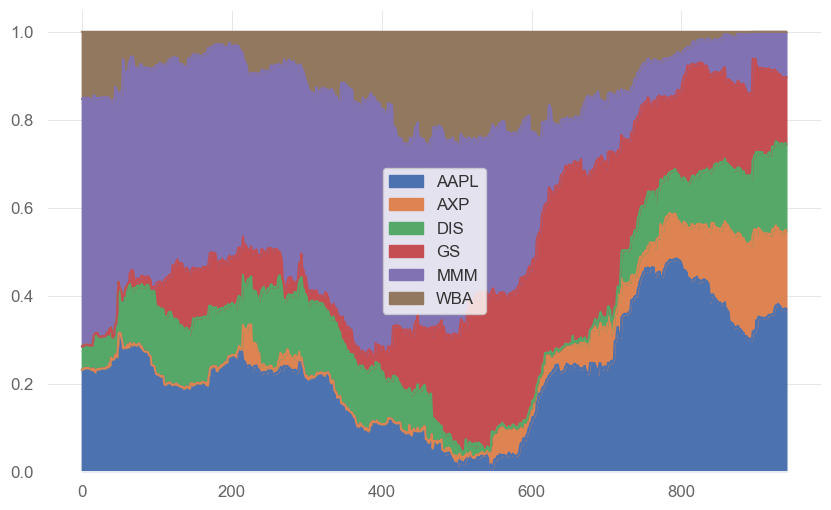

In [10]:
%matplotlib inline
eights = pd.DataFrame(list_weights)
weights.columns =cleaned_data.tic.unique()
weights.plot(kind='area')
plt.show()


In [6]:
res = mvo.mean_variance_optimization(covariances,pct=0.003)

begin_total_asset:50000
end_total_asset:46520.4139881527
Sharpe:  0.07316297627631083
Test Finished!
episode_return 0.9304082797630541


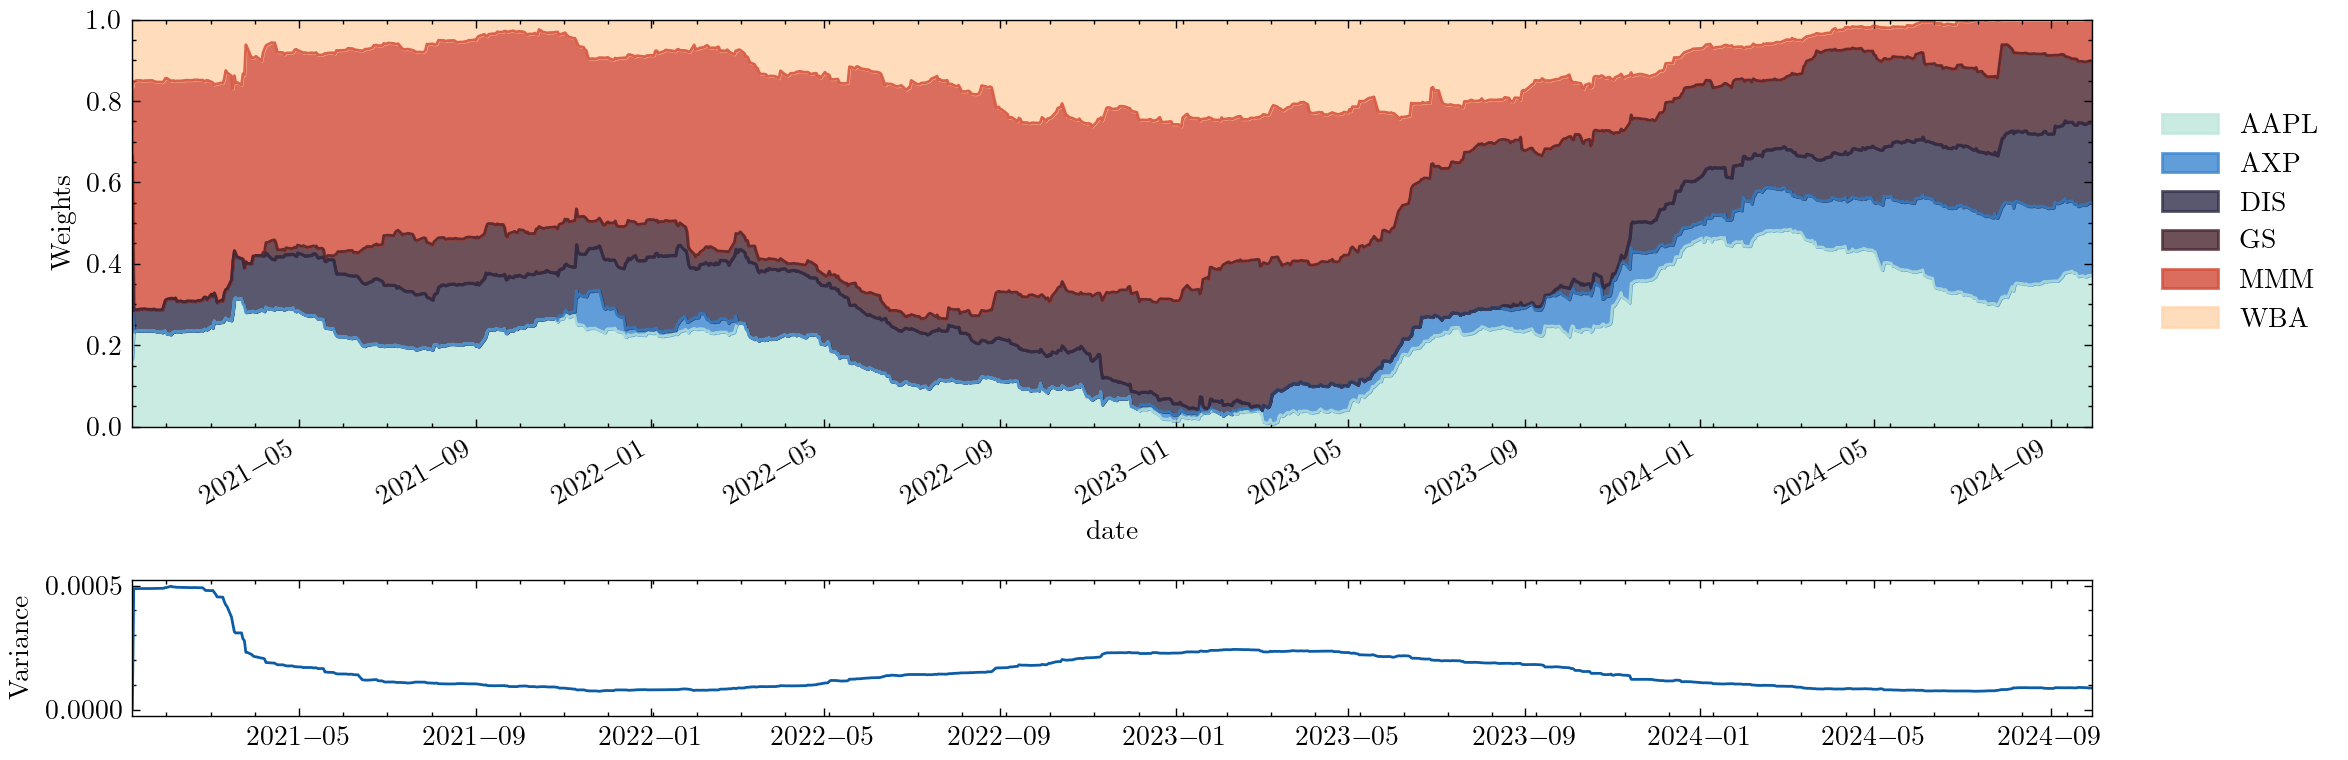

In [9]:
%matplotlib inline
plot_mvo_weights(res,test_data)

In [ ]:
res = mvo.mean_variance_optimization(covariances,pct=0.003,objective='sharpe',rf=0)

PPO WITHOUT WEIGHT

ppo_690000_steps
ppo_close_log_return_volatility_window_size_5_0.003_proximal_policy_optimization_simple_return

Successfully load model data\ppo_close_log_return_volatility_window_size_5_0.003_proximal_policy_optimization_simple_return\ppo_140000_steps
Initial portfolio value:250000
Final portfolio value: 331092.0625
Final accumulative portfolio value: 1.32436825
Maximum DrawDown: -0.27829259556143193
Sharpe ratio: 0.5144382752215
hit end!


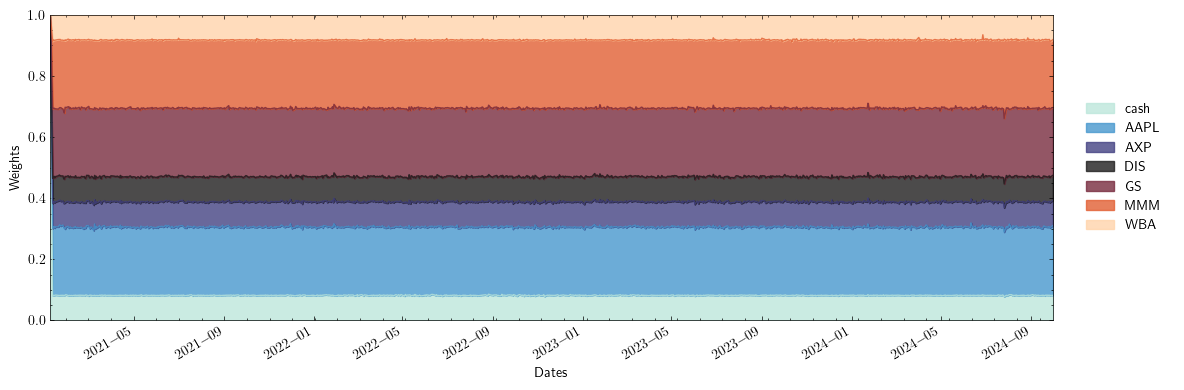

In [ ]:
from utils.plotting_helpers import plot_weights


optimizer = PortfolioOptimization(
    transaction_fee=0.003,comission_fee_model='trf', vectorize=False, tag="proximal_policy_optimization_simple_return", sharp_reward=False, last_weight=False, add_cash=True)
# optimizer.train_model(train_data,
#                         validation_data,
#                         features=["close", "log_return","volatility"],
#                         model_name="ppo",
#                         args={"n_steps":  256, "batch_size": 128},
#                         window_size=5,
#                         iterations=1000_000)
model = optimizer.load_from_file(
    'ppo', path="data\ppo_close_log_return_volatility_window_size_5_0.003_proximal_policy_optimization_simple_return\ppo_140000_steps")
test_result = optimizer.DRL_prediction(model, test_data, ["close", "log_return","volatility"])
from utils.plotting_helpers import plot_weights
plot_weights(test_result[0].weights, test_result[0].date, test_result[1])


In [ ]:
import torch


a2coptimizer = PortfolioOptimization(
    transaction_fee=0.003, vectorize=False,,comission_fee_model='trf', tag="a2c_simple_return", sharp_reward=False, last_weight=False, add_cash=True)
a2coptimizer.train_model(train_data,
                        validation_data,
                        features=["close", "log_return","volatility"],
                        model_name="a2c",
                        args={"n_steps": 21, "ent_coef": 0.01, "learning_rate": 0.0003},
                        policy_kwargs= dict(
                            net_arch=[64, 128],
                            activation_fn=torch.nn.ReLU
                        ),
                        window_size=5,
                        iterations=1000_000)